# Synthetic Philadelphia - Production Pipeline

Full rasterization pipeline with EPR destination diary generation.

In [1]:
from pathlib import Path
import time
import json
import geopandas as gpd
import pandas as pd
from shapely.geometry import box

import nomad.map_utils as nm
from nomad.city_gen import RasterCity
from nomad.traj_gen import Population
from tqdm import tqdm

## Configuration

In [2]:
LARGE_BOX = box(-75.1905, 39.9235, -75.1425, 39.9535)

USE_FULL_CITY = False
OUTPUT_DIR = Path("sandbox")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

if USE_FULL_CITY:
    BOX_NAME = "full"
    POLY = "Philadelphia, Pennsylvania, USA"
else:
    BOX_NAME = "large"
    POLY = LARGE_BOX

SANDBOX_GPKG = OUTPUT_DIR / f"sandbox_data_{BOX_NAME}.gpkg"
REGENERATE_DATA = False

config = {
    "box_name": BOX_NAME,
    "block_side_length": 15.0,
    "hub_size": 600,
    "N": 100,
    "name_seed": 42,
    "name_count": 2,
    "epr_params": {
        "datetime": "2024-01-01 00:00-05:00",
        "end_time": "2024-04-01 00:00-05:00",
        "epr_time_res": 15,
        "rho": 0.4,
        "gamma": 0.3,
        "seed_base": 100
    }
}

## Data Generation (OSM Download + Rotation)

In [3]:
if REGENERATE_DATA or not SANDBOX_GPKG.exists():
    print("="*50)
    print("DATA GENERATION")
    print("="*50)
    
    t0 = time.time()
    buildings = nm.download_osm_buildings(
        POLY,
        crs="EPSG:3857",
        schema="garden_city",
        clip=True,
        infer_building_types=True,
        explode=True,
    )
    download_buildings_time = time.time() - t0
    print(f"Buildings download: {download_buildings_time:>6.2f}s ({len(buildings):,} buildings)")
    
    if USE_FULL_CITY:
        boundary_polygon = nm.get_city_boundary_osm(POLY, simplify=True)[0]
        boundary_polygon = gpd.GeoSeries([boundary_polygon], crs="EPSG:4326").to_crs("EPSG:3857").iloc[0]
    else:
        boundary_polygon = gpd.GeoDataFrame(geometry=[POLY], crs="EPSG:4326").to_crs("EPSG:3857").geometry.iloc[0]
    
    outside_mask = ~buildings.geometry.within(boundary_polygon)
    if outside_mask.any():
        buildings = gpd.clip(buildings, gpd.GeoDataFrame(geometry=[boundary_polygon], crs="EPSG:3857"))
    buildings = nm.remove_overlaps(buildings).reset_index(drop=True)
    
    t1 = time.time()
    streets = nm.download_osm_streets(
        POLY,
        crs="EPSG:3857",
        clip=True,
        explode=True,
        graphml_path=OUTPUT_DIR / "streets_consolidated.graphml",
    )
    download_streets_time = time.time() - t1
    print(f"Streets download:   {download_streets_time:>6.2f}s ({len(streets):,} streets)")
    
    streets = streets.reset_index(drop=True)
    
    t2 = time.time()
    rotated_streets, rotation_deg = nm.rotate_streets_to_align(streets, k=200)
    rotation_time = time.time() - t2
    print(f"Grid rotation:      {rotation_time:>6.2f}s ({rotation_deg:.2f}°)")
    
    rotated_buildings = nm.rotate(buildings, rotation_deg=rotation_deg)
    rotated_boundary = nm.rotate(
        gpd.GeoDataFrame(geometry=[boundary_polygon], crs="EPSG:3857"),
        rotation_deg=rotation_deg
    )
    
    if SANDBOX_GPKG.exists():
        SANDBOX_GPKG.unlink()
    
    rotated_buildings.to_file(SANDBOX_GPKG, layer="buildings", driver="GPKG")
    rotated_streets.to_file(SANDBOX_GPKG, layer="streets", driver="GPKG", mode="a")
    rotated_boundary.to_file(SANDBOX_GPKG, layer="boundary", driver="GPKG", mode="a")
    
    data_gen_time = download_buildings_time + download_streets_time + rotation_time
    print("-"*50)
    print(f"Data generation:    {data_gen_time:>6.2f}s")
    print("="*50 + "\n")
else:
    print(f"Loading existing data from {SANDBOX_GPKG}")
    data_gen_time = 0.0

buildings = gpd.read_file(SANDBOX_GPKG, layer="buildings")
streets = gpd.read_file(SANDBOX_GPKG, layer="streets")
boundary = gpd.read_file(SANDBOX_GPKG, layer="boundary")

Loading existing data from sandbox\sandbox_data_large.gpkg


## Rasterization Pipeline

In [4]:
print("="*50)
print("RASTERIZATION PIPELINE")
print("="*50)

t0 = time.time()
city = RasterCity(
    boundary.geometry.iloc[0],
    streets,
    buildings,
    block_side_length=config["block_side_length"],
    resolve_overlaps=True,
    other_building_behavior="filter"
)
gen_time = time.time() - t0
print(f"City generation:    {gen_time:>6.2f}s")

t1 = time.time()
G = city.get_street_graph()
graph_time = time.time() - t1
print(f"Street graph:       {graph_time:>6.2f}s")

t2 = time.time()
city._build_hub_network(hub_size=config["hub_size"])
hub_time = time.time() - t2
print(f"Hub network:        {hub_time:>6.2f}s")

t3 = time.time()
city.compute_gravity(exponent=2.0, callable_only=True)
grav_time = time.time() - t3
print(f"Gravity computation: {grav_time:>6.2f}s")

raster_time = gen_time + graph_time + hub_time + grav_time
print("-"*50)
print(f"Rasterization:      {raster_time:>6.2f}s")
print("="*50)

if data_gen_time > 0:
    total_time = data_gen_time + raster_time
    print(f"\nTotal (with data):  {total_time:>6.2f}s")

RASTERIZATION PIPELINE
Generated 104,188 blocks (in 4.47s)
Assigning block types...
Block types assigned (in 0.89s)
Assigning streets...
Verifying street connectivity...
  Streets: 28,195 kept, 0 discarded (in 0.27s)
Adding buildings to city...
  Added 19368 buildings, skipped 21247 due to overlap (adding took 7.45s)
City generation:     18.76s
Street graph:         0.22s
Hub network:         16.23s
Gravity computation:   7.56s
--------------------------------------------------
Rasterization:       42.77s


## Summary: City Structure

In [5]:
def get_size_mb(obj):
    if isinstance(obj, (pd.DataFrame, gpd.GeoDataFrame)):
        return obj.memory_usage(deep=True).sum() / 1024**2
    elif hasattr(obj, 'nodes') and hasattr(obj, 'edges'):
        return (len(obj.nodes) * 64 + len(obj.edges) * 96) / 1024**2
    else:
        return 0.0

summary_df = pd.DataFrame({
    'Component': ['Blocks', 'Streets', 'Buildings', 'Graph Nodes', 'Graph Edges', 'Hub Network', 'Hub Info', 'Nearby Doors', 'Gravity (callable)'],
    'Count/Shape': [
        f"{len(city.blocks_gdf):,}",
        f"{len(city.streets_gdf):,}",
        f"{len(city.buildings_gdf):,}",
        f"{len(G.nodes):,}",
        f"{len(G.edges):,}",
        f"{city.hub_df.shape[0]}×{city.hub_df.shape[1]}",
        f"{city.grav_hub_info.shape[0]}×{city.grav_hub_info.shape[1]}",
        f"{len(city.mh_dist_nearby_doors):,} pairs",
        "function"
    ],
    'Memory (MB)': [
        f"{get_size_mb(city.blocks_gdf):.1f}",
        f"{get_size_mb(city.streets_gdf):.1f}",
        f"{get_size_mb(city.buildings_gdf):.1f}",
        f"{get_size_mb(G):.1f}",
        "-",
        f"{get_size_mb(city.hub_df):.1f}",
        f"{get_size_mb(city.grav_hub_info):.1f}",
        f"{get_size_mb(city.mh_dist_nearby_doors):.1f}",
        "<0.1"
    ]
})
print("\n" + summary_df.to_string(index=False))
print(city.buildings_gdf.building_type.value_counts())


         Component   Count/Shape Memory (MB)
            Blocks       104,188        16.5
           Streets        28,195         3.6
         Buildings        19,368         5.9
       Graph Nodes        28,195         4.6
       Graph Edges        31,259           -
       Hub Network       561×561         2.4
          Hub Info       19368×2         1.4
      Nearby Doors 204,719 pairs         0.0
Gravity (callable)      function        <0.1
building_type
home         18569
retail         429
workplace      203
park           167
Name: count, dtype: int64


## Generate Population and Destination Diaries

In [6]:
print("\n" + "="*50)
print("DESTINATION DIARY GENERATION")
print("="*50)

config_path = OUTPUT_DIR / f"config_{BOX_NAME}.json"
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

population = Population(city)
population.generate_agents(
    N=config["N"],
    seed=config["name_seed"],
    name_count=config["name_count"],
    datetimes=config["epr_params"]["datetime"]
)

end_time = pd.Timestamp(config["epr_params"]["end_time"])

t1 = time.time()
for i, agent in tqdm(enumerate(population.roster.values()), total=config["N"]):
    agent.generate_dest_diary(
        end_time=end_time,
        epr_time_res=config["epr_params"]["epr_time_res"],
        rho=config["epr_params"]["rho"],
        gamma=config["epr_params"]["gamma"],
        seed=config["epr_params"]["seed_base"] + i
    )

diary_gen_time = time.time() - t1
print(f"Diary generation:   {diary_gen_time:>6.2f}s")

total_entries = sum(len(agent.destination_diary) for agent in population.roster.values())
print(f"Total entries:      {total_entries:,}")

dest_diaries_path = OUTPUT_DIR / f"dest_diaries_{BOX_NAME}"
t2 = time.time()
population.save_pop(
    dest_diaries_path=dest_diaries_path,
    partition_cols=["date"],
    fmt='parquet',
    traj_cols={'geohash': 'location'}
)
persist_time = time.time() - t2
print(f"Persistence:        {persist_time:>6.2f}s")
print("-"*50)
print(f"Total EPR:          {diary_gen_time:>6.2f}s")
print("="*50)

print(f"\nConfig saved to {config_path}")
print(f"Destination diaries saved to {dest_diaries_path}")


DESTINATION DIARY GENERATION


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [19:14<00:00, 11.54s/it]


Diary generation:   1154.24s
Total entries:      94,569
Persistence:          1.05s
--------------------------------------------------
Total EPR:          1154.24s

Config saved to sandbox\config_large.json
Destination diaries saved to sandbox\dest_diaries_large


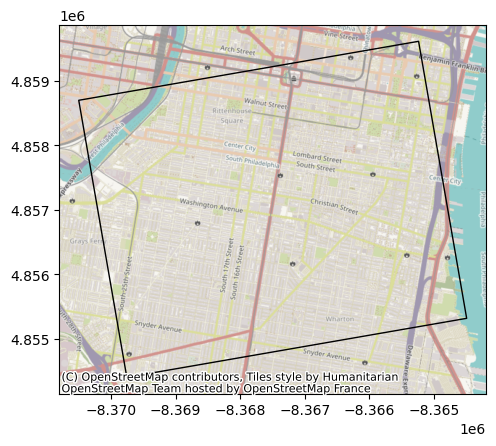

In [16]:
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt

box = gpd.GeoSeries(city.boundary_polygon)
fig, ax = plt.subplots()
box.plot(ax=ax, facecolor="None")
cx.add_basemap(ax, crs=box.crs)
plt.show()